In [80]:
import os
os.chdir("/dust3r")
print(os.getcwd())

/dust3r


In [81]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch
import re
import json
import open3d as o3d

DATA_PATH = "/dust3r/masked_dust3r/data/jackal_training_data_0"
DOWN_SAMPLE_VOXEL_SIZE = 0.0005
KEEP_PT_RATIO_LOWER = 0
KEEP_PT_RATIO_UPPER = 1

with open(os.path.join(DATA_PATH, "transforms.json"), "r") as f:
    transforms = json.load(f)


In [82]:
all_pc_points = []
all_tf = []
all_fl_x = []
all_fl_y = []
all_cx = []
all_cy = []
all_image_array = []

for transform_index in range(10,len(transforms["frames"])):
    tf = transforms["frames"][transform_index]["transform_matrix"]
    fl_x = transforms["frames"][transform_index]["fl_x"]
    fl_y = transforms["frames"][transform_index]["fl_y"]
    cx = transforms["frames"][transform_index]["cx"]
    cy = transforms["frames"][transform_index]["cy"]
    all_tf.append(tf)
    all_fl_x.append(fl_x)
    all_fl_y.append(fl_y)
    all_cx.append(cx)
    all_cy.append(cy)

    image_path = os.path.join(DATA_PATH, transforms["frames"][transform_index]["file_path"]) 
    all_image_array.append(image_path)
    image_path_array = re.split("\.|/",str(image_path))
    index = int(image_path_array[-2])
    pointcloud_path = os.path.join(DATA_PATH, "pointclouds", "pointcloud{}.ply".format(index))

    #Open pointcloud and project into camera plane
    pcd = o3d.io.read_point_cloud(pointcloud_path)
    pcd = pcd.voxel_down_sample(voxel_size=DOWN_SAMPLE_VOXEL_SIZE)
    all_pc_points.append(np.asarray(pcd.points))
    break

#Reshape all_pc_points to be a 2D array
all_pc_points = np.concatenate(all_pc_points, axis=0)
print(all_pc_points.shape)

(2585, 3)


In [83]:
#Keep only 10 percent of points furthest away from the centroid
centroid = np.mean(all_pc_points, axis=0)
distances = np.linalg.norm((all_pc_points - centroid)[:,:2], axis=1)
distances = all_pc_points[:,2]
indices = np.argsort(distances)
indices = indices[::-1]
far_points = all_pc_points[indices[int(KEEP_PT_RATIO_LOWER*all_pc_points.shape[0],):int(KEEP_PT_RATIO_UPPER*all_pc_points.shape[0])]]

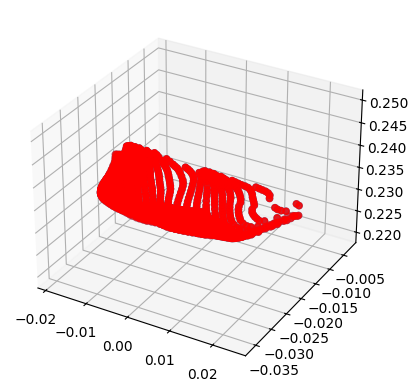

In [84]:
#Plot the pointcloud
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(all_pc_points[:,0], all_pc_points[:,1], all_pc_points[:,2])
ax.scatter(far_points[:,0], far_points[:,1], far_points[:,2], color="red")


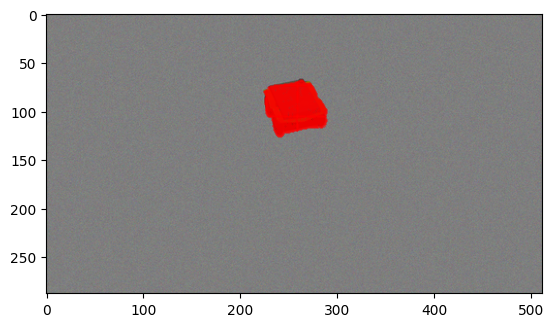

In [85]:
OPENGL = np.array([[1, 0, 0, 0],
                    [0, -1, 0, 0],
                    [0, 0, -1, 0],
                    [0, 0, 0, 1]])

for i in range(len(transforms["frames"])):
    #Intrinsics matrix
    K = np.array([[all_fl_x[i], 0, all_cx[i], 0],
                    [0, all_fl_y[i], all_cy[i], 0],
                    [0, 0, 1, 0]])
    #Extrinsics matrix
    tf = np.array(all_tf[i])
    tf = np.linalg.inv(tf)
    tf = np.dot(OPENGL,tf)
    #tf = np.linalg.inv(tf)
    
    #Project the points
    points = far_points
    points = np.concatenate((points, np.ones((points.shape[0], 1))), axis=1)
    points = np.dot(points, tf.T)
    points = np.dot(points, K.T)
    points = points[:,:2]/points[:,2].reshape(-1,1)

    #Plot the points over original image
    image = Image.open(all_image_array[i])
    #Resize image
    image = image.resize((int(K[0,2]*2), int(K[1,2]*2)), Image.Resampling.LANCZOS)



    fig, ax = plt.subplots()
    ax.imshow(image)
    ax.scatter(points[:,0], points[:,1], color="red", s=0.1)
    break